# A Homicide and Shooting Early Warning System for Baltimore City

Using Baltimore Police crime data, computer vision, and convolutional neural networks to recognize patterns in mapping and alert authorities to the potential for violence.

---

## Overview

Historically, the majority of the violent crime which plagues Baltimore City has occured as a byprodict of the illicit drug trade - conflicts stemming from the distribtion of those drugs. A majority of these incidents of homicide and shooting are tied to outside, open air "drug shops" throughout the city. As we can see below, when comparing homicide and shooting events to all other crimes, they occur outdoors in a disproptionately higher level. 

<img src="/Images/Outside.png">

The fact that these crimes occur outside means that if we were able to anticipate them, officers could theoretically be deployed to areas of traditionally high violence, thus potentially preventing them.

Simply searching "baltimore city violence" yields pages of articles tying homicides and shootings within the city to drug gangs and repeat offenders.

Problem corners are known, drug shop locations where violence occur are known. The heatmap below shows five years worth of data with highly concentrated areas of homicide/shooting occurrence.

<img src="/Images/HeatMap.png">

## Goal

The goal of this project will be to create a model which finds hidden patterns in the flow of reported crime throughout the city, in an attempt to be able to provide a warning of possible impending violence. No system like this currently exists for comparison. Simple time series analsysis forecasting has proven unreliable as a primary means of prediction. Too many other factors are at play. To those ends we will try utilizing computer vision and deep learning neural netwroks to our advantage. Using images which consist of 2 hour snapshots of crime within the city (plotted to a map) the model will attempt to classify what it sees upon that map as a distribution that is likely to include a homicide/shooting or one that is not. Crime type and neighborhoods where crime is occuring will also be highlighted. A model like this, if deployed to a real time environment, could sound a warning within the police department when a homicide is likely. Officers could then be rapidly deployed to known violence hotspots, in an attempt to prevent potential homicides.

## The Data

The primary dataset which will be used in this analysis is the victim based part 1 crime table, produced by the Baltimore City Police Department. It reports crimes based upon each victim, rather than occurance, and thus each row can be thought of as a victim. The dataset at the time I accessed it consisted of almost 280,000 records and 22 columns. 

The model chosen for this project will use computer vision techniques and neural networks to accomplish the goals we have laid out. Thus, this tabular crime data needed to be transformed into geospaital image data. To these ends, data from 01/01/2014 through 10/31/2020 was used to produce over 29,000 individual maps, harnessing the included Lat Long features of the original dataset. Each map represents a 2 hour window in time. All crimes which took place within that window are plotted onto the map as a color coded point. Additionally, neighborhood outlines within the city are included. Any neighborhood which experienced a crime of any type during this time is highlighted in red, all others are in black. Please find an example of the map images generated below:

<table><tr>
<td> <img src="Images/201401_03407.png" style="width: 500px;"/> </td>
<td> <img src="Images/Legend.png" style="width: 500px;"/> </td>
</tr></table>

Due to the amount/length of work which went into creating our image data, the details involving how it was created have been included in a separate notebook, located [here](https://github.com/yeagercmbpd/HomicideEarlyWarning_UsingCNNandComputerVision/blob/main/Notebooks/Data%20Preparation%20and%20Creation.ipynb)

For the sake of training the model it must be noted that out of the 29,000+ images only 4,824 included a homicide/shooting event. Thus, the overall size of the data elligible for use would be 9,648 so as to ensure an even split between the binary classes of "homicide/shooting" and "no homicide/shooting" 

## The Models

To solve this problem I employed tensorflow and keras in order to produce a deep learning neural network which was improved by adding convolutional layers. Two attempts were made at training a model which was able to classify a map image with a great enough accuracy to be useful in achieving our goals. For both models, computational cost in training was high enough that I was forced to abandon my normal laptop and employ the use of a new one which possessed a dedicated GPU. Tensorflow with GPU support was loaded successfully and made training these models feasible.

The primary difference between model 1 and 2 lies in data augmentation. As stated above, in order to maintain balance, the size of our avaialble training data was limited by the number of instances containing a homicide/shooting to 9648. While model 2 was not much more complex than model 1, it was able to acheive much greater accuracy, which I attribute to augmentation (allowing for more epochs with less overfitting as well).

The final model was too large to upload to github, but can be found for download at this [link](https://drive.google.com/file/d/1prIrIrSKg7gqFidqo2DjTF0g7dSDD88g/view?usp=sharing)

---
*note: Due to the size and complexity of this project, I am unable to provide a finished dataset and flowing notebook which incorporates all aspects of it. The final data file is over half a gig in size and as such I was not able to upload it. All notebooks and original data links to reproduce this work are found within this respository, along with the notebooks used to create each model, and a link to the copy of the final saved model.*


## Model 1

In [3]:
#Import necessary Libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm
import pickle
import shutil
import random

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import time

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard

In [ ]:
#The number of images for each classification needed to be balanced. This places the same number of non homshoot images into a dir
dirpath = "C:/Users/yeage/Desktop/UMBC/DATA 602/Final/Maps/None"
destDirectory = "C:/Users/yeage/Desktop/UMBC/DATA 602/Final/Maps/NoneSelected"
filenames = random.sample(os.listdir(dirpath), 4824)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    shutil.copy(srcpath, destDirectory)

Now that we have the images we must make them consumable by the model. These are color images and for some reason not all of them saved as the same size. The code below reads the image files in from their repsective directories, converts them to arrays, resizes them as needed, and creates a new object training_data
Assistance from: https://pythonprogramming.net/introduction-deep-learning-python-tensorflow-keras/

In [ ]:
DATADIR = "C:/Users/yeage/Desktop/UMBC/DATA 602/Final/Maps"

CATEGORIES = ["NoneSelected", "Hom"]

#Color Test

training_data = []

def create_training_data():
    for category in CATEGORIES:  # found above, has hom/shoot or not

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=hom 1=no hom

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array,(172,216)) # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data))

In [ ]:
#mix up the training data categories
random.shuffle(training_data)

In [ ]:
plt.imshow(training_data[1][0])

In [ ]:
#Split the labels and images into separate variables.
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

In [ ]:
#Save our processed data using pickle
pickle_out = open("FinalRGB_X2hr.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("FinalRGB_y2hr.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

Now that the data has been formatted properly, the below code block is where the model is actually created, compiled, and fitted. I have opted to use the sequential method to write this, as we can see below, the model consists of 3 convolutional layers and 2 fully connected/dense layers. The first convolutional layer consists of 128 filters, which are 3x3 in size output will be same size as input. The subsiquent 2 Conv layers use 64 filters 3x3 then 2x2 in size to derive feature values. Max pooling is used after each convolutional layer to reduce the size of the output, further distilling the value of the features. In these steps the maximum value from each of the pool sizes is kept and the others are discarded. 

This output is then fed into a fully connected hidden layer of 64 neurons, then 32. All layers of the model up to this point have used a rectified linear activation function

Finally, the output layer is a single node, utilizing a sigmoid activation since we are working with a binary classification problem. The Adam optimization function was selected for this model. Several learning rates were tested, as well as the implementation of a decay and momentum input for the gradient descent fine tuning. default settings and a learning rate of 1e-3 were settled on for final fitting. batch size of 20 were used over 10 epochs and built in train test split were used at 15%.



In [7]:
#This could not be included in the final upload as it was nearly a gig in size
pickle_in = open("NeuralNetwork/FinalRGB_X2hr.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("NeuralNetwork/FinalRGB_y2hr.pickle","rb")
y = pickle.load(pickle_in)
y=np.array(y)

In [13]:
#The size of our image. 216x172 pixels with 3 layers due to RGB color
X[0].shape

(216, 172, 3)

In [ ]:
NAME = "MapHomClass-CNN-128-64x2-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir=".\logs{}".format(NAME))


#XX = np.array(X)#/255.0
X=tf.keras.utils.normalize(X, axis=-1, order=2)

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=X.shape[1:],padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3),padding='valid'))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3),padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

#opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#opt = Adam(lr=0.01, decay=1e-6)
opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'], optimizer = opt)

model.fit(X, y, batch_size=20, epochs=20, validation_split=0.15, shuffle=True,callbacks=[tensorboard])

The last five training epochs were as follows. 

Epoch 15/20
8200/8200 [==============================] - 25s 3ms/sample - loss: 0.5789 - accuracy: 0.6916 - val_loss: 0.6719 - val_accuracy: 0.6202
Epoch 16/20
8200/8200 [==============================] - 25s 3ms/sample - loss: 0.5672 - accuracy: 0.7015 - val_loss: 0.6914 - val_accuracy: 0.6070
Epoch 17/20
8200/8200 [==============================] - 25s 3ms/sample - loss: 0.5542 - accuracy: 0.7124 - val_loss: 0.6946 - val_accuracy: 0.6167
Epoch 18/20
8200/8200 [==============================] - 25s 3ms/sample - loss: 0.5391 - accuracy: 0.7220 - val_loss: 0.7378 - val_accuracy: 0.5953
Epoch 19/20
8200/8200 [==============================] - 25s 3ms/sample - loss: 0.5276 - accuracy: 0.7320 - val_loss: 0.7009 - val_accuracy: 0.6022
Epoch 20/20
8200/8200 [==============================] - 25s 3ms/sample - loss: 0.5108 - accuracy: 0.7451 - val_loss: 0.7560 - val_accuracy: 0.5988

Now lets take a look at how this model performed using tensorboard!

In [15]:
%load_ext tensorboard
#%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
%tensorboard --logdir=logs/

There is a log file in the repository containing the tensorboard callback files, however, in case tensorboard doesn't want to cooperate, Ive included the screenshots below:


<img src="/Images/Model1TensorboardScreenCap.PNG">

As we can see, the validation accuracy measured over 20 epochs only gets to around 60%, not a great result. Also, taking a look at the tensorboard output we see a huge divergence between training loss and validation loss. we also see a decreasing validation accuracy as the epochs go on. I attributed this to the model potentially memorizing the inputs and overfitting the data.

At this point I decided to scrap this model and try again.

## Model 2

This model would use the template from week 12 of our class as inspiration. The idea of data augmentation to stretch the effectiveness of a small sample size was a solution that I hoped would help make this idea work. To begin, as with class directories for each category would be created and train valid and test sample data would be placed into each one using shutl.

In [ ]:
base_dir = 'CrimeMaps_small'

try:
    os.mkdir(base_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass


train_dir = os.path.join(base_dir, 'train')
try:
    os.mkdir(train_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

validation_dir = os.path.join(base_dir, 'validation')
try:
    os.mkdir(validation_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

test_dir = os.path.join(base_dir, 'test')
try:
    os.mkdir(test_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Directory with our training Hom maps 
train_cats_dir = os.path.join(train_dir, 'Hom')
try:
    os.mkdir(train_cats_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
# Directory with our training No Hom maps 
train_dogs_dir = os.path.join(train_dir, 'None')
try:
    os.mkdir(train_dogs_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
# Directory with our validation pictures
validation_cats_dir = os.path.join(validation_dir, 'Hom')
try:
    os.mkdir(validation_cats_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

validation_dogs_dir = os.path.join(validation_dir, 'None')
os.mkdir(validation_dogs_dir)

# Directory with our test pictures
test_cats_dir = os.path.join(test_dir, 'Hom')
try:
    os.mkdir(test_cats_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
test_dogs_dir = os.path.join(test_dir, 'None')
try:
    os.mkdir(test_dogs_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

__Hom__

In [3]:
original_dataset_dir = 'C:/Users/yeage/Desktop/UMBC/DATA 602/Final/Maps'

In [4]:
import random
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(random.sample(os.listdir(original_dataset_dir+'/Hom'), 4800), test_size = 1/8)
train, val = train_test_split(train, test_size = 0.1)

In [6]:
for fname in train:
    src = os.path.join(original_dataset_dir, 'Hom', fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
for fname in val:
    src = os.path.join(original_dataset_dir, 'Hom', fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
for fname in test:
    src = os.path.join(original_dataset_dir, 'Hom', fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

__No Hom__

In [9]:
train, test = train_test_split(random.sample(os.listdir(original_dataset_dir+'/None'), 4800), test_size = 1/8)
train, val = train_test_split(train, test_size = .1)

original_dataset_dir = original_dataset_dir+'/None'

# Copy first 1000 dog images to train_dogs_dir
for fname in train:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
for fname in val:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
for fname in test:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
print('total training Hom images:', len(os.listdir(train_cats_dir)))

total training Hom images: 3780


In [11]:
print('total training No Hom images:', len(os.listdir(train_dogs_dir)))

total training No Hom images: 3780


In [12]:
print('total validation Hom images:', len(os.listdir(validation_cats_dir)))

total validation Hom images: 420


In [13]:
print('total validation No Hom images:', len(os.listdir(validation_dogs_dir)))

total validation No Hom images: 420


In [14]:
print('total test Hom images:', len(os.listdir(test_cats_dir)))

total test Hom images: 600


In [15]:
print('total test No Hom images:', len(os.listdir(test_dogs_dir)))

total test No Hom images: 600


Note that 4800 images from each category were used, as that was the approximate total number of cases in which the map contained a hom/shoot.

In [16]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

The model was left as it was. The notable differences between this model and model 1 are that there is an additional convolutional layer and only 1 (much larger) dense layer. the convolutional layers also start smaller and grow, which is the opposite of model 1.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

As explained in the description of model 1 the first conv layer in this model consists of 32 3x3 filters. In the summary above we see that this translates into 896 parameters. This is derived from 3x3 = 9 x 32 total = 288. There are 3 channels as this is a color image so 288x3 is 864. The Last 32 are bias values. Taking a look at the first pooling layer we see that 2x2 pooling reduced the output shape by half. This continues until we reach the dense layer were a huge number of parameters are calculated using the information gleaned from the convolutional processes. We compile the model below and create our tensorboard log.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "MapHomClass-Augment-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir=".\logs{}".format(NAME))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])



In [22]:
#Here we use flow from direcotry to begin writing the code which will feed the various types of data to the model during fitting
#The augmentation function will use these flows
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 7560 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [23]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [ ]:
#This code block keeps my graphics card from melting. Memory leakage was causing the training to error out due to insufficient
#RAM. This frees up GPU memory as you go and prevents tf from ever maxing the card out.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Train a few epochs without agumenting. Here we see this model is already outperforming model 1 by a great deal

In [26]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=20,callbacks=[tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 378 steps, validate for 20 steps
Epoch 1/10
378/378 [==============================] - 36s 94ms/step - loss: 0.6897 - acc: 0.5380 - val_loss: 0.6694 - val_acc: 0.5975
Epoch 2/10
378/378 [==============================] - 9s 23ms/step - loss: 0.6625 - acc: 0.6049 - val_loss: 0.6550 - val_acc: 0.5950
Epoch 3/10
378/378 [==============================] - 8s 22ms/step - loss: 0.6477 - acc: 0.6163 - val_loss: 0.6412 - val_acc: 0.6300
Epoch 4/10
378/378 [==============================] - 8s 22ms/step - loss: 0.6385 - acc: 0.6325 - val_loss: 0.6635 - val_acc: 0.6500
Epoch 5/10
378/378 [==============================] - 8s 22ms/step - loss: 0.6312 - acc: 0.6421 - val_loss: 0.6333 - val_acc: 0.6450
Epoch 6/10
378/378 [==============================] - 8s 22ms/step - loss: 0.6209 - acc: 0.6578 - val_loss: 0.6503 - val_acc: 0.6450
Epoch 7/10
378/378 [==============================] - 9s 22ms/step - loss: 0.6083 - acc: 0.6685 - val_loss: 

Here is where the data augmentation comes in. the datagen object below will allow the augmentor to rotate, shift, flip, and zoom images as they flow from the direcotry and into the training of the model. I adjusted these values to be slightly more modest since we are dealing with geographic areas which may be more spatially sensitive. 

In [28]:
datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

In [29]:
os.path#.join(CrimeMaps_small)
original_dataset_dir+'/CrimeMaps_small'

'C:/Users/yeage/Desktop/UMBC/DATA 602/Final/Maps/None/CrimeMaps_small'

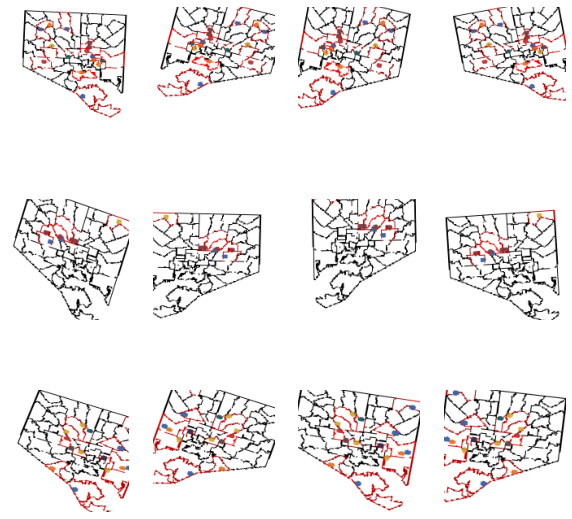

In [30]:
#Here is a visual example of what the data augmentor is doing with its inputs.

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

plt.figure(figsize=(10, 10))
image_list = []
## creating the image list as arrays
for img in [image.load_img(img_path, target_size=(150, 150)) for img_path in random.sample(fnames, 3)]:
  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  ## Data Augmentation
  j = 0
  for batch in datagen.flow(x, batch_size=1):
    image_list.append(image.array_to_img(batch[0]))
    j+=1
    if j % 4==0:
      break

## plotting
for i, img in enumerate(image_list):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")

In [33]:
NAME = "MapHomClass-Augment-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir=".\logs\{}".format(NAME))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = trained_model.fit_generator(
      train_generator,
      epochs=50,
      validation_data=validation_generator,callbacks=[tensorboard])

Found 7560 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 237 steps, validate for 27 steps
Epoch 1/50
237/237 [==============================] - 32s 134ms/step - loss: 0.5686 - acc: 0.7021 - val_loss: 0.5510 - val_acc: 0.7190
Epoch 2/50
237/237 [==============================] - 32s 135ms/step - loss: 0.5549 - acc: 0.7093 - val_loss: 0.5820 - val_acc: 0.6940
Epoch 3/50
237/237 [==============================] - 32s 135ms/step - loss: 0.5503 - acc: 0.7176 - val_loss: 0.5138 - val_acc: 0.7464
Epoch 4/50
237/237 [==============================] - 32s 135ms/step - loss: 0.5432 - acc: 0.7246 - val_loss: 0.5019 - val_acc: 0.7536
Epoch 5/50
237/237 [==============================] - 32s 135ms/step - loss: 0.5315 - acc: 0.7263 - val_loss: 0.5232 - val_acc: 0.7429
Epoch 6/50
237/237 [==============================] - 32s 135ms/step - loss: 0.5284 - acc: 0.7357 - val_loss: 0.5179 - val_acc: 0.7405
Epoch 7/50
237

Vastly superior result!!! we see a steady but incremental decline in both training and validation loss, as well as the same steady increase in accuracy. Our final accuracy after 50 epochs (technically 60) is hovering around 80%. Lets take a look at the tensorboard output to visualize this.

In [18]:
%tensorboard --logdir=logs/

<img src="/Images/Model2bTensorboardScreenCap.PNG">

Much more smooth. The green and pink are the first 10 runs, the orange and grey are the subsequent 50 using augmentation.

Now that we have a model we're pleased with, we save it.

<img src="/Images/Model2TensorboardScreenCap.PNG">

In [ ]:
trained_model.save('IdentifyingHomShootTimespans_augmented_model2HR_Best.h5')
trained_model = load_model('IdentifyingHomShootTimespans_augmented_model2HR_Best.h5')

Using our saved model we can now see how it performs using our test data (which the model has never seen up to this point). We will do this in batches of 15.

In [148]:
(a) = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=15,
        class_mode='binary')

Found 1200 images belonging to 2 classes.


In [175]:
b = next(a)

In [176]:
b[1].shape

(15,)

In [177]:
b[0].shape

(15, 150, 150, 3)

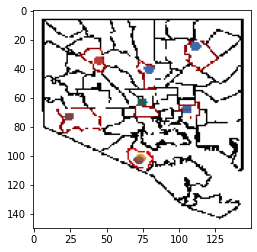

In [178]:
plt.imshow(np.reshape(b[0][4], (150, 150, 3)))

In [179]:
label2=[]
for i in range(15):
    label2.append(b[1][i])

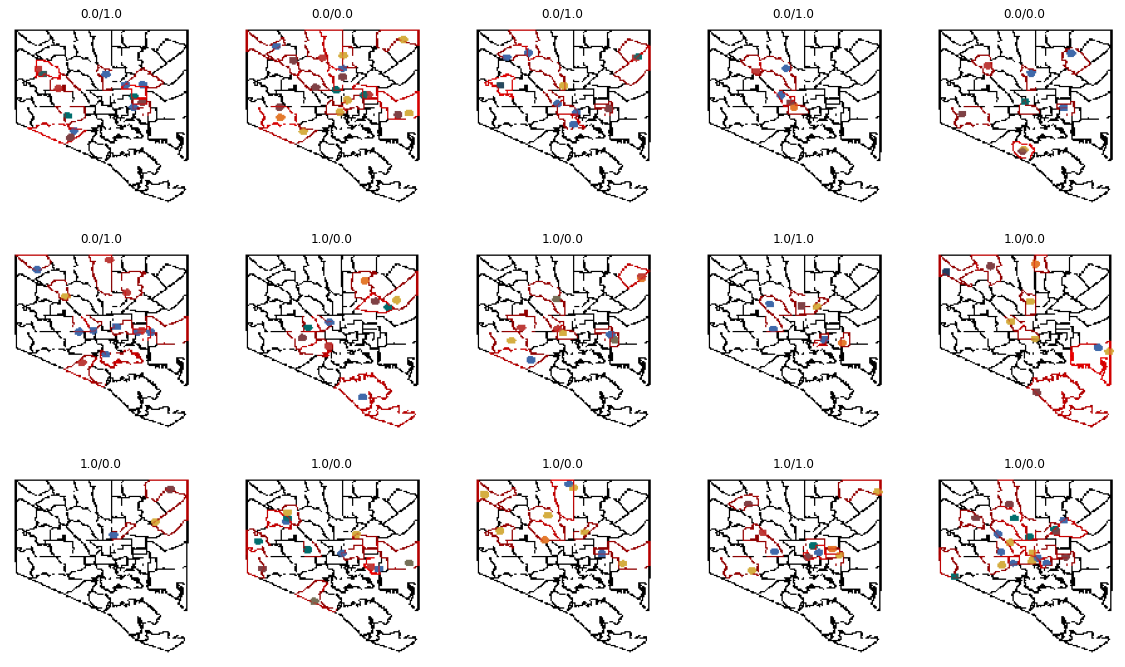

In [180]:
#Here are our 15 samples along with their respective labels

fig = plt.figure(figsize=(20, 20))
for i in range(15):
    
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(b[0][i])
    plt.title(str(label2[i]))
    plt.axis("off")


In [181]:
#Have our model make its predictions using this input
predictions=trained_model.predict(b)

In [182]:
Lablz=np.round(predictions).tolist()

In [183]:
flat_list = []
for sublist in Lablz:
    for item in sublist:
        flat_list.append(item)

In [184]:
#Compare the predictions to the real labels and get % accuracy
correct=sum(x == y for x, y in zip(label2,flat_list))

In [185]:
total=len(flat_list)

In [186]:
print("The percentage of accurate matches from the test set is: "+str(round(correct/total*100,2))+"%")

The percentage of accurate matches from the test set is: 80.0%


80% is a fantastic result! Let make sure this isn't an outlier result. The loop below runs this 50 more times and calculates the average accuracy

In [231]:
aggacc=[]
for i in range(50):
    b = next(a)

    label2=[]
    for i in range(15):
        label2.append(b[1][i])


    predictions=trained_model.predict(b)

    Lablz=np.round(predictions).tolist()

    flat_list = []
    for sublist in Lablz:
        for item in sublist:
            flat_list.append(item)

    correct=sum(x == y for x, y in zip(label2,flat_list))

    total=len(flat_list)

    print("The percentage of accurate matches from the test set is: "+str(round(correct/total*100,2))+"%")
    aggacc.append(round(correct/total*100,2))

The percentage of accurate matches from the test set is: 80.0%
The percentage of accurate matches from the test set is: 86.67%
The percentage of accurate matches from the test set is: 93.33%
The percentage of accurate matches from the test set is: 93.33%
The percentage of accurate matches from the test set is: 86.67%
The percentage of accurate matches from the test set is: 60.0%
The percentage of accurate matches from the test set is: 80.0%
The percentage of accurate matches from the test set is: 93.33%
The percentage of accurate matches from the test set is: 66.67%
The percentage of accurate matches from the test set is: 66.67%
The percentage of accurate matches from the test set is: 93.33%
The percentage of accurate matches from the test set is: 93.33%
The percentage of accurate matches from the test set is: 80.0%
The percentage of accurate matches from the test set is: 86.67%
The percentage of accurate matches from the test set is: 73.33%
The percentage of accurate matches from the 

In [232]:
import statistics
statistics.mean(aggacc)

78.4004

#### Deployment

Let's now go one step further and do a simulated implementation of this model as it would be used in reality. We will take a snapshot of one day in the city and use a rolling two hour window to generate maps and feed them into our model. Hopefully, when the model recognizes a potential for violence, it will alert. We will 'refresh' the map (slide the rolling window) every ten minutes, which means we will have approximately 130 map images for our 2 hour window, in our 24 hour day.

The day we will look at is 11/28/2020 (most recent data available). The code which produced the maps can be found [here](https://github.com/yeagercmbpd/HomicideEarlyWarning_UsingCNNandComputerVision/blob/main/Notebooks/OneDay_Model_Depoyment_DataGen.ipynb). The code below formats the maps to work with the model and makes our predictions.

In [123]:
test_generator.reset()

In [124]:
#Images need to be bruoght in and formatted in the way the model expects them to be
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "Maps/TestRun",
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=False)

Found 129 images belonging to 2 classes.


In [126]:
# model predictions
pred=trained_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

26/26 [==============================] - 0s 14ms/step


In [127]:
# round the predictions
cl = np.round(pred)
# Get filenames (set shuffle=false in generator is important)
filenames=test_generator.filenames

In [128]:
# read to Data frame
results=pd.DataFrame({"file":filenames,"pr":pred[:,0], "class":cl[:,0]})

In [129]:
results['time']=results['file'].str.extract('(\d+)')

In [130]:
results=results.sort_values('time')

In [131]:
results['label'] = results['file'].str[-8]

In [139]:
results['label'].replace(to_replace = 'T', value=1,inplace=True)

In [140]:
results['label'].replace(to_replace = 'a', value=0,inplace=True)

In [141]:
Intercept=results[(results['time'] >= '100000') & (results['time'] <= '110000')]

As we can see below, there is some room for improvement. Looking at the green line, which represents predictions, We have 2 potentially false posative alerts. One Alert is accurate and falls in line with a shooting which occured. Finally, one shooting is totally missed by the model. That being said, even catching a signle incident could result in lives saved. 

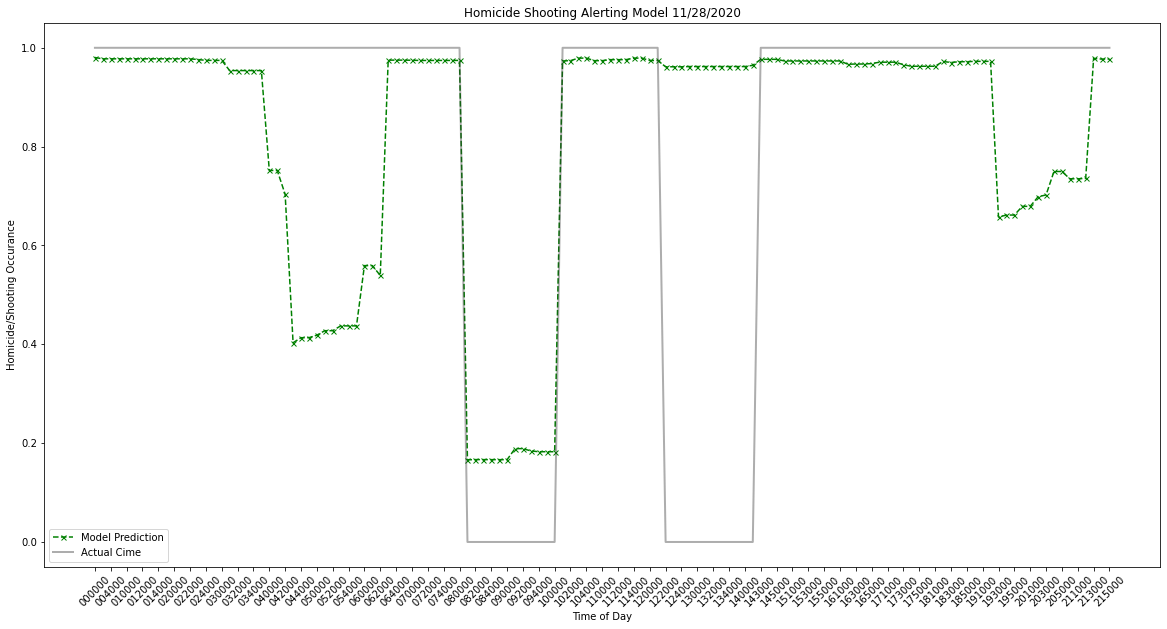

In [151]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(results['time'],results['pr'], marker='x', markersize=5, color='green',
linestyle='--', label='Model Prediction')
ax.plot(results['time'],results['label'], color='0.2', linewidth=2,label='Actual Cime',alpha=.4)

ax.set_xticks(ax.get_xticks()[::2])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend()
ax.set_xlabel('Time of Day')
ax.set_ylabel('Homicide/Shooting Occurance')
ax.set_title('Homicide Shooting Alerting Model 11/28/2020');


fig.savefig('11282020_deployment1.png',bbox_inches='tight')

# Conclusion

We have managed to acheive our goal and train a model which can look at snapshots of crime in space and time within Baltimore City and make a prediction as to whether or not a homicide/shooting event is likely to occur. Our concept has been proven as being possible.

Moving forward, improvements can certainly be made to this existing model. Fine tuning of model structure and hyperparameters could likely yield a slightly better performing model. This could include tweaking such things as the learning rate, implementing decay in different forms, finding the best activation, optimization, and loss functions, or adjusting the number and structure of the different layers. Training for additional ephocs would also almost certainly help, the model was still steadily improving where we left off. 

Adding additional data to the map images could also help in making more accurate predictions. Calls for service points, demographics, historic crime trends, and narcotics intelligence could all be added and suppliment the model.

experimenting with lagging the model may also allow for an increased amount of warning time before a potential incident. 

As building a neural network is, in the words of Andrew Ng, a "very emprical process" we know that more fine tuning can be done here. Due to time constraints and computing capabilities I was not able to explore all of the possibities available to producing the absolute best model within my working window. What we have come up with is a model which proves our idea is feasible and that can provide the promise of a tool which could help in stemming the violent crime epidemic in Baltimore City.